# Classification des images à l'aide d'algorithmes de Deep Learning (CNN)

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import cv2
import time
import json
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as k
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import initializers
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from PIL import Image

In [4]:
# Création de repertoire de stockage d'images
import requests
import tarfile
dataset_path = "Projet_Stanford_Dogs"
if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

In [45]:
# Télécharge des images sur le site Stanfors
packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
packet_file = os.path.basename(packet_url)
packet_file = os.path.join(dataset_path, packet_file)
with requests.get(packet_url, stream = True) as r:
    r.raise_for_status()
    with open(packet_file, "wb") as f:
        for chunk in r.iter_content(chunk_size = 8192):
            f.write(chunk)
with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)

#######
packet_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"
packet_file = os.path.basename(packet_url)
packet_file = os.path.join(dataset_path, packet_file)
with requests.get(packet_url, stream = True) as r:
    r.raise_for_status()
    with open(packet_file, "wb") as f:
        for chunk in r.iter_content(chunk_size = 8192):
            f.write(chunk)
with tarfile.open(packet_file) as tfile:
    tfile.extractall(dataset_path)


KeyboardInterrupt



## Importation des images

In [5]:
# On recuperer les races 
print(os.listdir("Projet_Stanford_Dogs/Images/")[:20])
breed_list = os.listdir("Projet_Stanford_Dogs/Images/")

['n02089973-English_foxhound', 'n02099712-Labrador_retriever', 'n02113799-standard_poodle', 'n02110806-basenji', 'n02104365-schipperke', 'n02096585-Boston_bull', 'n02100236-German_short-haired_pointer', 'n02094258-Norwich_terrier', 'n02105251-briard', 'n02110958-pug', 'n02100583-vizsla', 'n02100735-English_setter', 'n02108551-Tibetan_mastiff', 'n02086646-Blenheim_spaniel', 'n02085620-Chihuahua', 'n02096177-cairn', 'n02099429-curly-coated_retriever', 'n02091635-otterhound', 'n02102040-English_springer', 'n02107142-Doberman']


In [6]:
breeds = [breed.split('-',1)[1] for breed in breed_list]
print(len(breeds))
print("\n")

120




In [30]:
# Obtention des étiquettes des chiens
# Obtention des étiquettes en divisant le nom du dossier au tiret

breeds = [breed.split('-',1)[1] for breed in breed_list]
print(len(breeds))
print("\n")

# view same of the labels
breed_selected = breeds[:20]
print("les 20 races sélectionnés :\n\n", breed_selected)

120


les 20 races sélectionnés :

 ['English_foxhound', 'Labrador_retriever', 'standard_poodle', 'basenji', 'schipperke', 'Boston_bull', 'German_short-haired_pointer', 'Norwich_terrier', 'briard', 'pug', 'vizsla', 'English_setter', 'Tibetan_mastiff', 'Blenheim_spaniel', 'Chihuahua', 'cairn', 'curly-coated_retriever', 'otterhound', 'English_springer', 'Doberman']


# L'analyse exploratoire des données

## Affichage d'une grille d'images pour visualiser le contenu des données
##### On affiche les 24 images de chiens aléatoirement  

Text(0.5, 0.98, 'Quelques Images de Chiens')

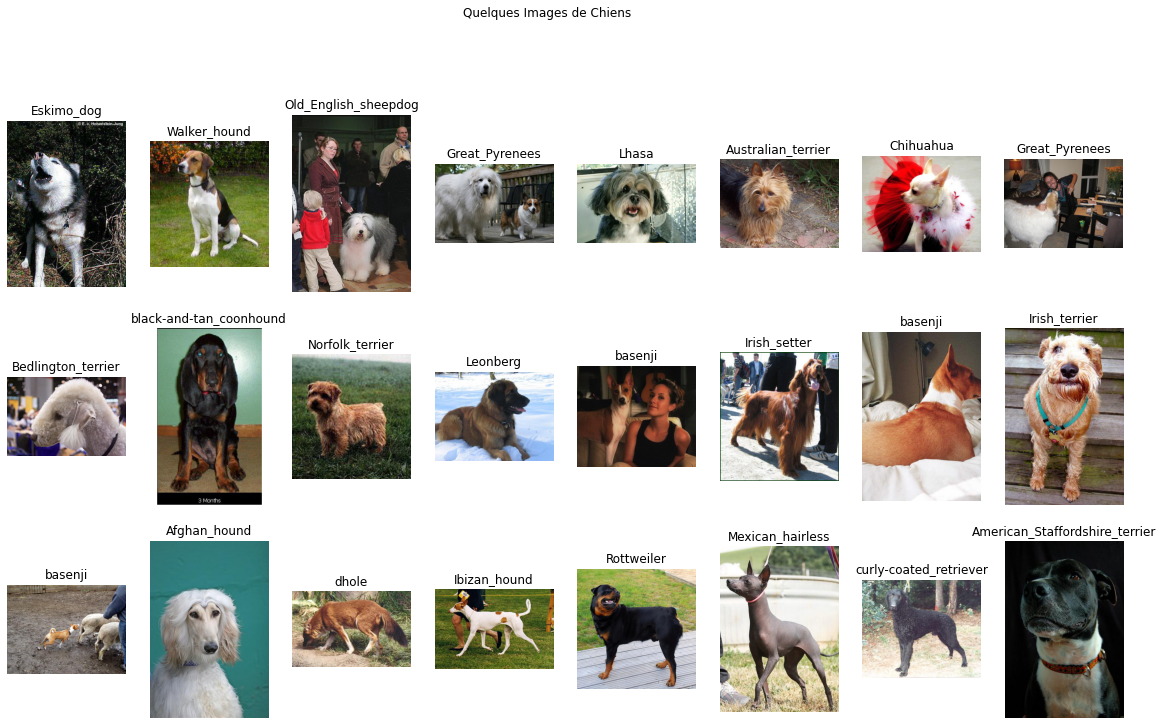

In [48]:
#  Train images
fig = plt.figure(figsize=(20, 15))
for i in range(24): 
    axs = fig.add_subplot(4,8,i+1)
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir("Projet_Stanford_Dogs/Annotation/" + breed))
    img = Image.open("Projet_Stanford_Dogs/Images/" + breed + "/" + dog + ".jpg")
    tree = ET.parse("Projet_Stanford_Dogs/Annotation/" + breed +"/" + dog)
    root = tree.getroot()
    object_1 = root = tree.findall("object")[0];
    name = object_1.find("name").text;
    axs.set_title(name)
    plt.imshow(img)
    plt.axis("off")
    
plt.suptitle("Quelques Images de Chiens")

## Création de label index

In [49]:
breed_list.sort()


label2index = dict((name, index) for index, name in enumerate(breed_list))

index2label = dict(( index, name) for index, name in enumerate(breed_list))

images = []

annotations = []

for breed in breed_list:
    
    image_files = os.listdir("Projet_Stanford_Dogs/Images/" + breed)
    
    image_files.sort()
    
    images.extend([os.path.join("Projet_Stanford_Dogs/Images/" + breed, f) for f in image_files])
    
    annotations.extend([os.path.join("Projet_Stanford_Dogs/Annotations/", breed, f.replace(".jpg", "")) for f in image_files])

    
for idx, ann in enumerate(annotations):
    
    annotations[idx] = ann.split("/")[2]
    

## Data Train & Label

In [50]:
Xs = np.asarray(images)

Ys = np.asarray(annotations)

print("Xs shape", Xs.shape)

print(Xs[:5])
print("\n")
print("Ys shape", Ys.shape)

print(Ys[:5])


Xs shape (20580,)
['Projet_Stanford_Dogs/Images/n02085620-Chihuahua/n02085620_10074.jpg'
 'Projet_Stanford_Dogs/Images/n02085620-Chihuahua/n02085620_10131.jpg'
 'Projet_Stanford_Dogs/Images/n02085620-Chihuahua/n02085620_10621.jpg'
 'Projet_Stanford_Dogs/Images/n02085620-Chihuahua/n02085620_1073.jpg'
 'Projet_Stanford_Dogs/Images/n02085620-Chihuahua/n02085620_10976.jpg']


Ys shape (20580,)
['n02085620-Chihuahua' 'n02085620-Chihuahua' 'n02085620-Chihuahua'
 'n02085620-Chihuahua' 'n02085620-Chihuahua']


## Nous allons Choisir 1000 obsevation pour la modélisation 

In [70]:
X = Xs[:1000]

y = Ys[:1000]

In [71]:
# Nous  avons 6 races dans notre échantillons (1000)
re = np.unique(y)
re

array(['n02085620-Chihuahua', 'n02085782-Japanese_spaniel',
       'n02085936-Maltese_dog', 'n02086079-Pekinese',
       'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel'], dtype='<U40')

## Conversion des labels en numérique

In [53]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [54]:
# Label and one-hot encoding y labels
le = LabelEncoder()
le.fit(y)
y_target = to_categorical(le.transform(y), len(breed_selected))
print(y_target.shape)
y_target = np.array(y_target)

(1000, 20)


## Repartition de données en données d'entrainement et données test

In [55]:
from keras.preprocessing.image import img_to_array, load_img

In [56]:
# chargement, redimensionnement des images et les stocker sous forme de tableau

images = np.array([img_to_array(load_img(img, target_size = (299,299))) for img in X]) 

x_train, x_test, y_train, y_test = train_test_split(images, y_target, test_size = 0.3,stratify = np.array(y), random_state = 120) 

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size = 0.3,stratify=np.array(y_train),random_state = 120)

print('Training Dataset Size: ', x_train.shape)
print("\n")

print('Training Label Size: ', y_train.shape)
print("\n")

print('Validation Dataset Size: ', x_val.shape)
print("\n")

print('Validation Label Size: ', y_val.shape)
print("\n")

print('Testing Dataset Size: ', x_test.shape)
print("\n")

print('Testing Label Size: ', y_test.shape)

import gc
del images
gc.collect()

Training Dataset Size:  (490, 299, 299, 3)


Training Label Size:  (490, 20)


Validation Dataset Size:  (210, 299, 299, 3)


Validation Label Size:  (210, 20)


Testing Dataset Size:  (300, 299, 299, 3)


Testing Label Size:  (300, 20)


114

## Traitement des données 

In [57]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [58]:
batch_size = 32
# Data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
)


train_generator = train_datagen.flow(x_train,y_train,shuffle=False,batch_size = batch_size)

In [59]:
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

valid_generator = val_datagen.flow(x_val, y_val, shuffle = False, batch_size = batch_size)

In [60]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = val_datagen.flow(x_test, y_test, shuffle = False, batch_size = batch_size)

### Image augmentée

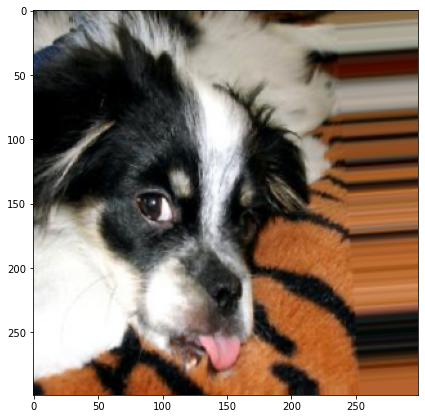

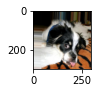

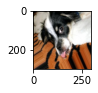

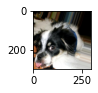

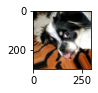

In [61]:
img_id = 8
dog_generator = train_datagen.flow(x_train[img_id:img_id+1], y_train[img_id:img_id+1],
                              shuffle = False, batch_size = batch_size, seed=2)
plt.figure(figsize=(40, 30))
dogs = [next(dog_generator) for i in range(0,5)]
for counter, dog in enumerate(dogs):
    plt.subplot(1, 5, counter+1)
    plt.imshow(dog[0][0])
    plt.show()

# Modèle 1 : Convolutional Neurl Network 

In [38]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, concatenate
from keras.layers import Dropout, Flatten, Dense

In [116]:
model_cnn = Sequential()

model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation = 'relu'))
model_cnn.add(Dense(20, activation = 'softmax'))

In [117]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

In [118]:
model_cnn.compile(loss= 'categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate= 1e-3), metrics= ['accuracy'])

In [119]:
start_time_cnn = time.time()

history = model_cnn.fit(

    train_generator,
    
    batch_size = batch_size,
    
    epochs = 20,
    
    validation_data = valid_generator,
        
    verbose = 1, 
    
    shuffle = True)

excution_time_cnn = (time.time() - start_time_cnn)/60.0

print('Training time: {:.1f}s'.format(excution_time_cnn))

Epoch 1/20
16/16 [==============================] - 224s 13s/step - loss: 2.1616 - accuracy: 0.2163 - val_loss: 2.3822 - val_accuracy: 0.1857
Epoch 2/20
16/16 [==============================] - 215s 13s/step - loss: 1.7549 - accuracy: 0.2551 - val_loss: 1.8410 - val_accuracy: 0.2667
Epoch 3/20
16/16 [==============================] - 191s 12s/step - loss: 1.7214 - accuracy: 0.2367 - val_loss: 1.7248 - val_accuracy: 0.2524
Epoch 4/20
16/16 [==============================] - 186s 12s/step - loss: 1.6789 - accuracy: 0.3122 - val_loss: 2.1919 - val_accuracy: 0.2238
Epoch 5/20
16/16 [==============================] - 160s 10s/step - loss: 1.6567 - accuracy: 0.3245 - val_loss: 1.8469 - val_accuracy: 0.3333
Epoch 6/20
16/16 [==============================] - 157s 10s/step - loss: 1.6313 - accuracy: 0.3388 - val_loss: 2.3771 - val_accuracy: 0.2333
Epoch 7/20
16/16 [==============================] - 158s 10s/step - loss: 1.6274 - accuracy: 0.3082 - val_loss: 2.8412 - val_accuracy: 0.2762
Epoch 

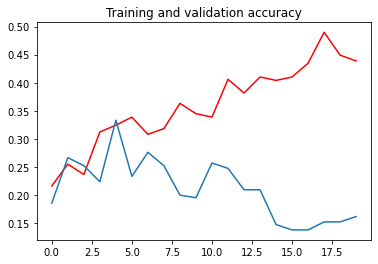

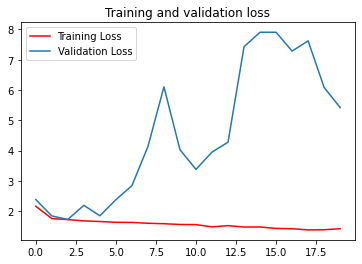

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, "r", label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, "r", label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [125]:
score = model_cnn.evaluate(test_generator, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 17.33%


In [129]:
image_path = "Projet_Stanford_Dogs/Images/n02085620-Chihuahua/n02085620_242.jpg" # path of the image
img = load_img(image_path, target_size=(299, 299))
img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 299, 299, 3) # reshape for prediction
pred = model_cnn.predict(img)

1/1 [==============================] - 1s 542ms/step


In [131]:
x_test1 = x_test/255.
#test_predictions 
test_predictions=model_cnn.predict(x_test1) 

## obtention des prédictions du modèle
predictions = le.classes_[np.argmax(test_predictions, axis = 1)] # get labels and reverse back to get the text labels

# Obtenir des modalités de variable cible
target_labels1 = le.classes_[np.argmax(y_test, axis = 1)]

10/10 [==============================] - 24s 2s/step


In [132]:
predict_df2 = pd.DataFrame({"Target_labels": target_labels1, "Predictions": predictions})
predict_df2.head(20)

Target_labels                 Predictions
0           n02086240-Shih-Tzu          n02086240-Shih-Tzu
1          n02085620-Chihuahua       n02085936-Maltese_dog
2          n02085620-Chihuahua       n02085936-Maltese_dog
3        n02085936-Maltese_dog          n02086079-Pekinese
4           n02086240-Shih-Tzu          n02086240-Shih-Tzu
5           n02086240-Shih-Tzu          n02086079-Pekinese
6           n02086240-Shih-Tzu          n02086240-Shih-Tzu
7        n02085936-Maltese_dog          n02086079-Pekinese
8           n02086079-Pekinese          n02086079-Pekinese
9        n02085936-Maltese_dog          n02086240-Shih-Tzu
10          n02086240-Shih-Tzu          n02086240-Shih-Tzu
11  n02085782-Japanese_spaniel  n02085782-Japanese_spaniel
12          n02086240-Shih-Tzu       n02085936-Maltese_dog
13  n02085782-Japanese_spaniel       n02085936-Maltese_dog
14  n02085782-Japanese_spaniel  n02085782-Japanese_spaniel
15       n02085936-Maltese_dog          n02086240-Shih-Tzu
16          n02086079-Pekinese          n02086079-Pekinese
17         n02085620-Chihuahua          n02086240-Shih-Tzu
18          n02086079-Pekinese          n02086240-Shih-Tzu
19  n02085782-Japanese_spaniel  n02085782-Japanese_spaniel

In [133]:
# Précision de la mesure

correct = (target_labels1 == predictions)
accuracy_cnn = correct.sum()/correct.size
print(accuracy_cnn)

0.3566666666666667


In [134]:
import random

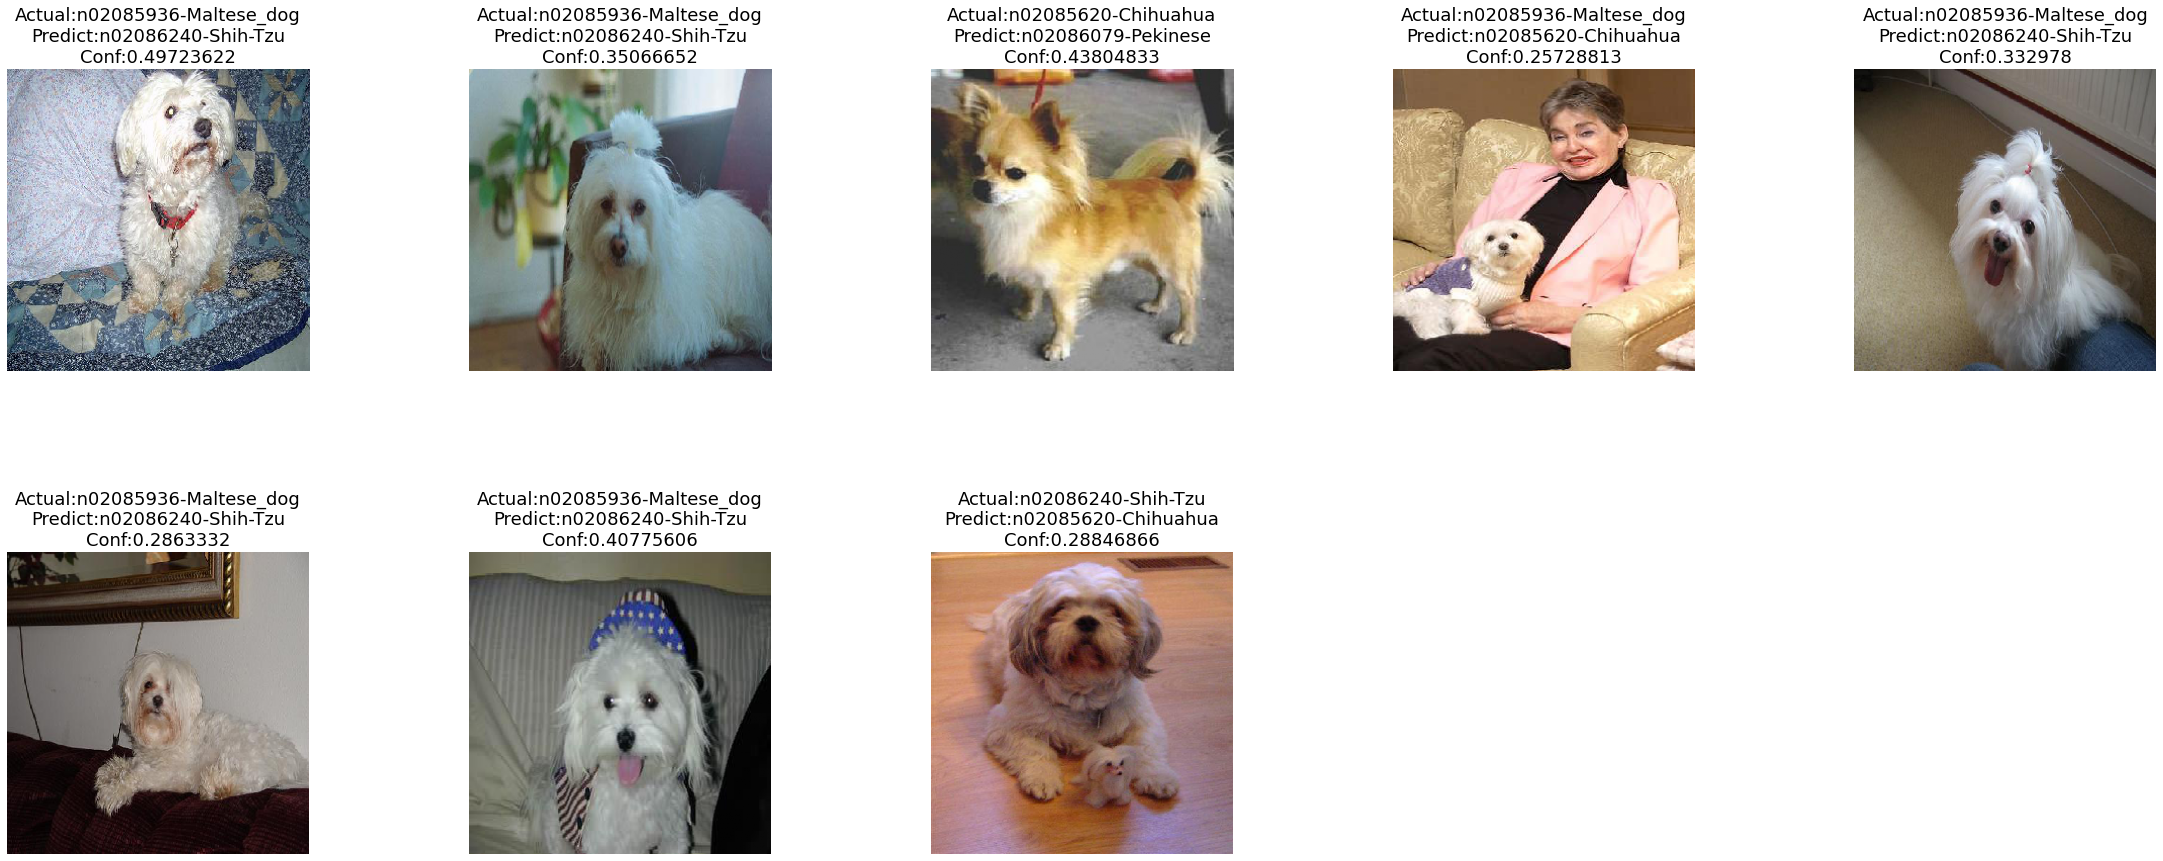

In [135]:
plt.figure(figsize = (40, 50))
for counter, i in enumerate(random.sample(range(0, len(y_test)), 8)):# random 30 images
    plt.subplot(6, 5, counter + 1)
    plt.subplots_adjust(hspace = 0.6)
    actual = str(target_labels1[i])
    predicted = str(predictions[i])
    conf = str(max(test_predictions[i]))    
    plt.imshow(x_test[i].astype(np.uint8) / 255)
    plt.axis("off")
    plt.title("Actual:" +actual+ "\nPredict:" +predicted+ "\nConf:" +conf, fontsize = 18)
    
plt.show()

## Modèle 2 : Transfert Learning inceptionV3

In [136]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D,  Activation
from tensorflow.keras.optimizers import Adam, RMSprop

In [137]:
pre_trained_model =  InceptionV3(weights = "imagenet", input_shape=(299,299,3), include_top= False)

for layer in pre_trained_model.layers:
    layer.trainable=False

87910968/87910968 [==============================] - 22s 0us/step


In [138]:
model = models.Sequential()
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten()) 
model.add(Dropout(0.3))
model.add(Dense(2048, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(breed_selected), activation = 'softmax'))

In [139]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-3), loss ='categorical_crossentropy', metrics =['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                      

In [140]:
epochs = 20
start_time = time.time()

history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = valid_generator, 
    verbose = 1)
excution_time = (time.time() - start_time)/60.0
print('Training time: {:.1f}s'.format(excution_time))

/tmp/ipykernel_6547/813302040.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
16/16 [==============================] - 216s 13s/step - loss: 1.1438 - accuracy: 0.5959 - val_loss: 0.4381 - val_accuracy: 0.8810
Epoch 2/20
16/16 [==============================] - 197s 12s/step - loss: 0.3423 - accuracy: 0.9041 - val_loss: 0.2280 - val_accuracy: 0.9333
Epoch 3/20
16/16 [==============================] - 198s 12s/step - loss: 0.2214 - accuracy: 0.9347 - val_loss: 0.2434 - val_accuracy: 0.9333
Epoch 4/20
16/16 [==============================] - 197s 13s/step - loss: 0.2354 - accuracy: 0.9204 - val_loss: 0.1950 - val_accuracy: 0.9429
Epoch 5/20
16/16 [==============================] - 198s 12s/step - loss: 0.1724 - accuracy: 0.9449 - val_loss: 0.2053 - val_accuracy: 0.9333
Epoch 6/20
16/16 [==============================] - 199s 12s/step - loss: 0.1644 - accuracy: 0.9490 - val_loss: 0.1447 - val_accuracy: 0.9619
Epoch 7/20
16/16 [==============================] - 198s 12s/step - loss: 0.1623 - accuracy: 0.9469 - val_loss: 0.1464 - val_accuracy: 0.9476
Epoch 

## Courbes d'apprentissage

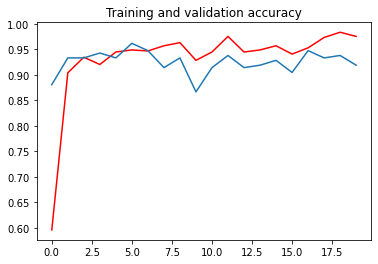

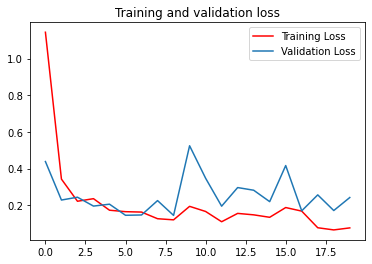

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, "r", label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()


plt.plot(epochs, loss, "r", label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [142]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy:', eval_accuracy)

7/7 [==============================] - 55s 8s/step - loss: 0.2417 - accuracy: 0.9190
Validation Loss:  0.24170419573783875
Validation Accuracy: 0.9190475940704346


In [143]:
x_test1 = test_generator 
# Prédiction sur la base test
test_predictions=model.predict(x_test1) 

# Obtention des prédictions du modèle
predictions = le.classes_[np.argmax(test_predictions, axis = 1)] 

# Obtention des étiquettes de la variables cible
target_labels = le.classes_[np.argmax(y_test, axis = 1)]

10/10 [==============================] - 82s 8s/step


## Stockage dans un dataframe

In [144]:
predict_df = pd.DataFrame({"Target_labels": target_labels, "Predictions": predictions})

In [145]:
predict_df.head(10)

Target_labels            Predictions
0     n02086240-Shih-Tzu     n02086240-Shih-Tzu
1    n02085620-Chihuahua    n02085620-Chihuahua
2    n02085620-Chihuahua    n02085620-Chihuahua
3  n02085936-Maltese_dog  n02085936-Maltese_dog
4     n02086240-Shih-Tzu     n02086240-Shih-Tzu
5     n02086240-Shih-Tzu     n02086240-Shih-Tzu
6     n02086240-Shih-Tzu     n02086240-Shih-Tzu
7  n02085936-Maltese_dog  n02085936-Maltese_dog
8     n02086079-Pekinese     n02086079-Pekinese
9  n02085936-Maltese_dog  n02085936-Maltese_dog

## Précision de la mesure

In [146]:
# Précision de la mesure

correct = (target_labels == predictions)
accuracy_v3 = correct.sum()/correct.size
print(accuracy_v3)

0.9666666666666667


In [147]:
import random

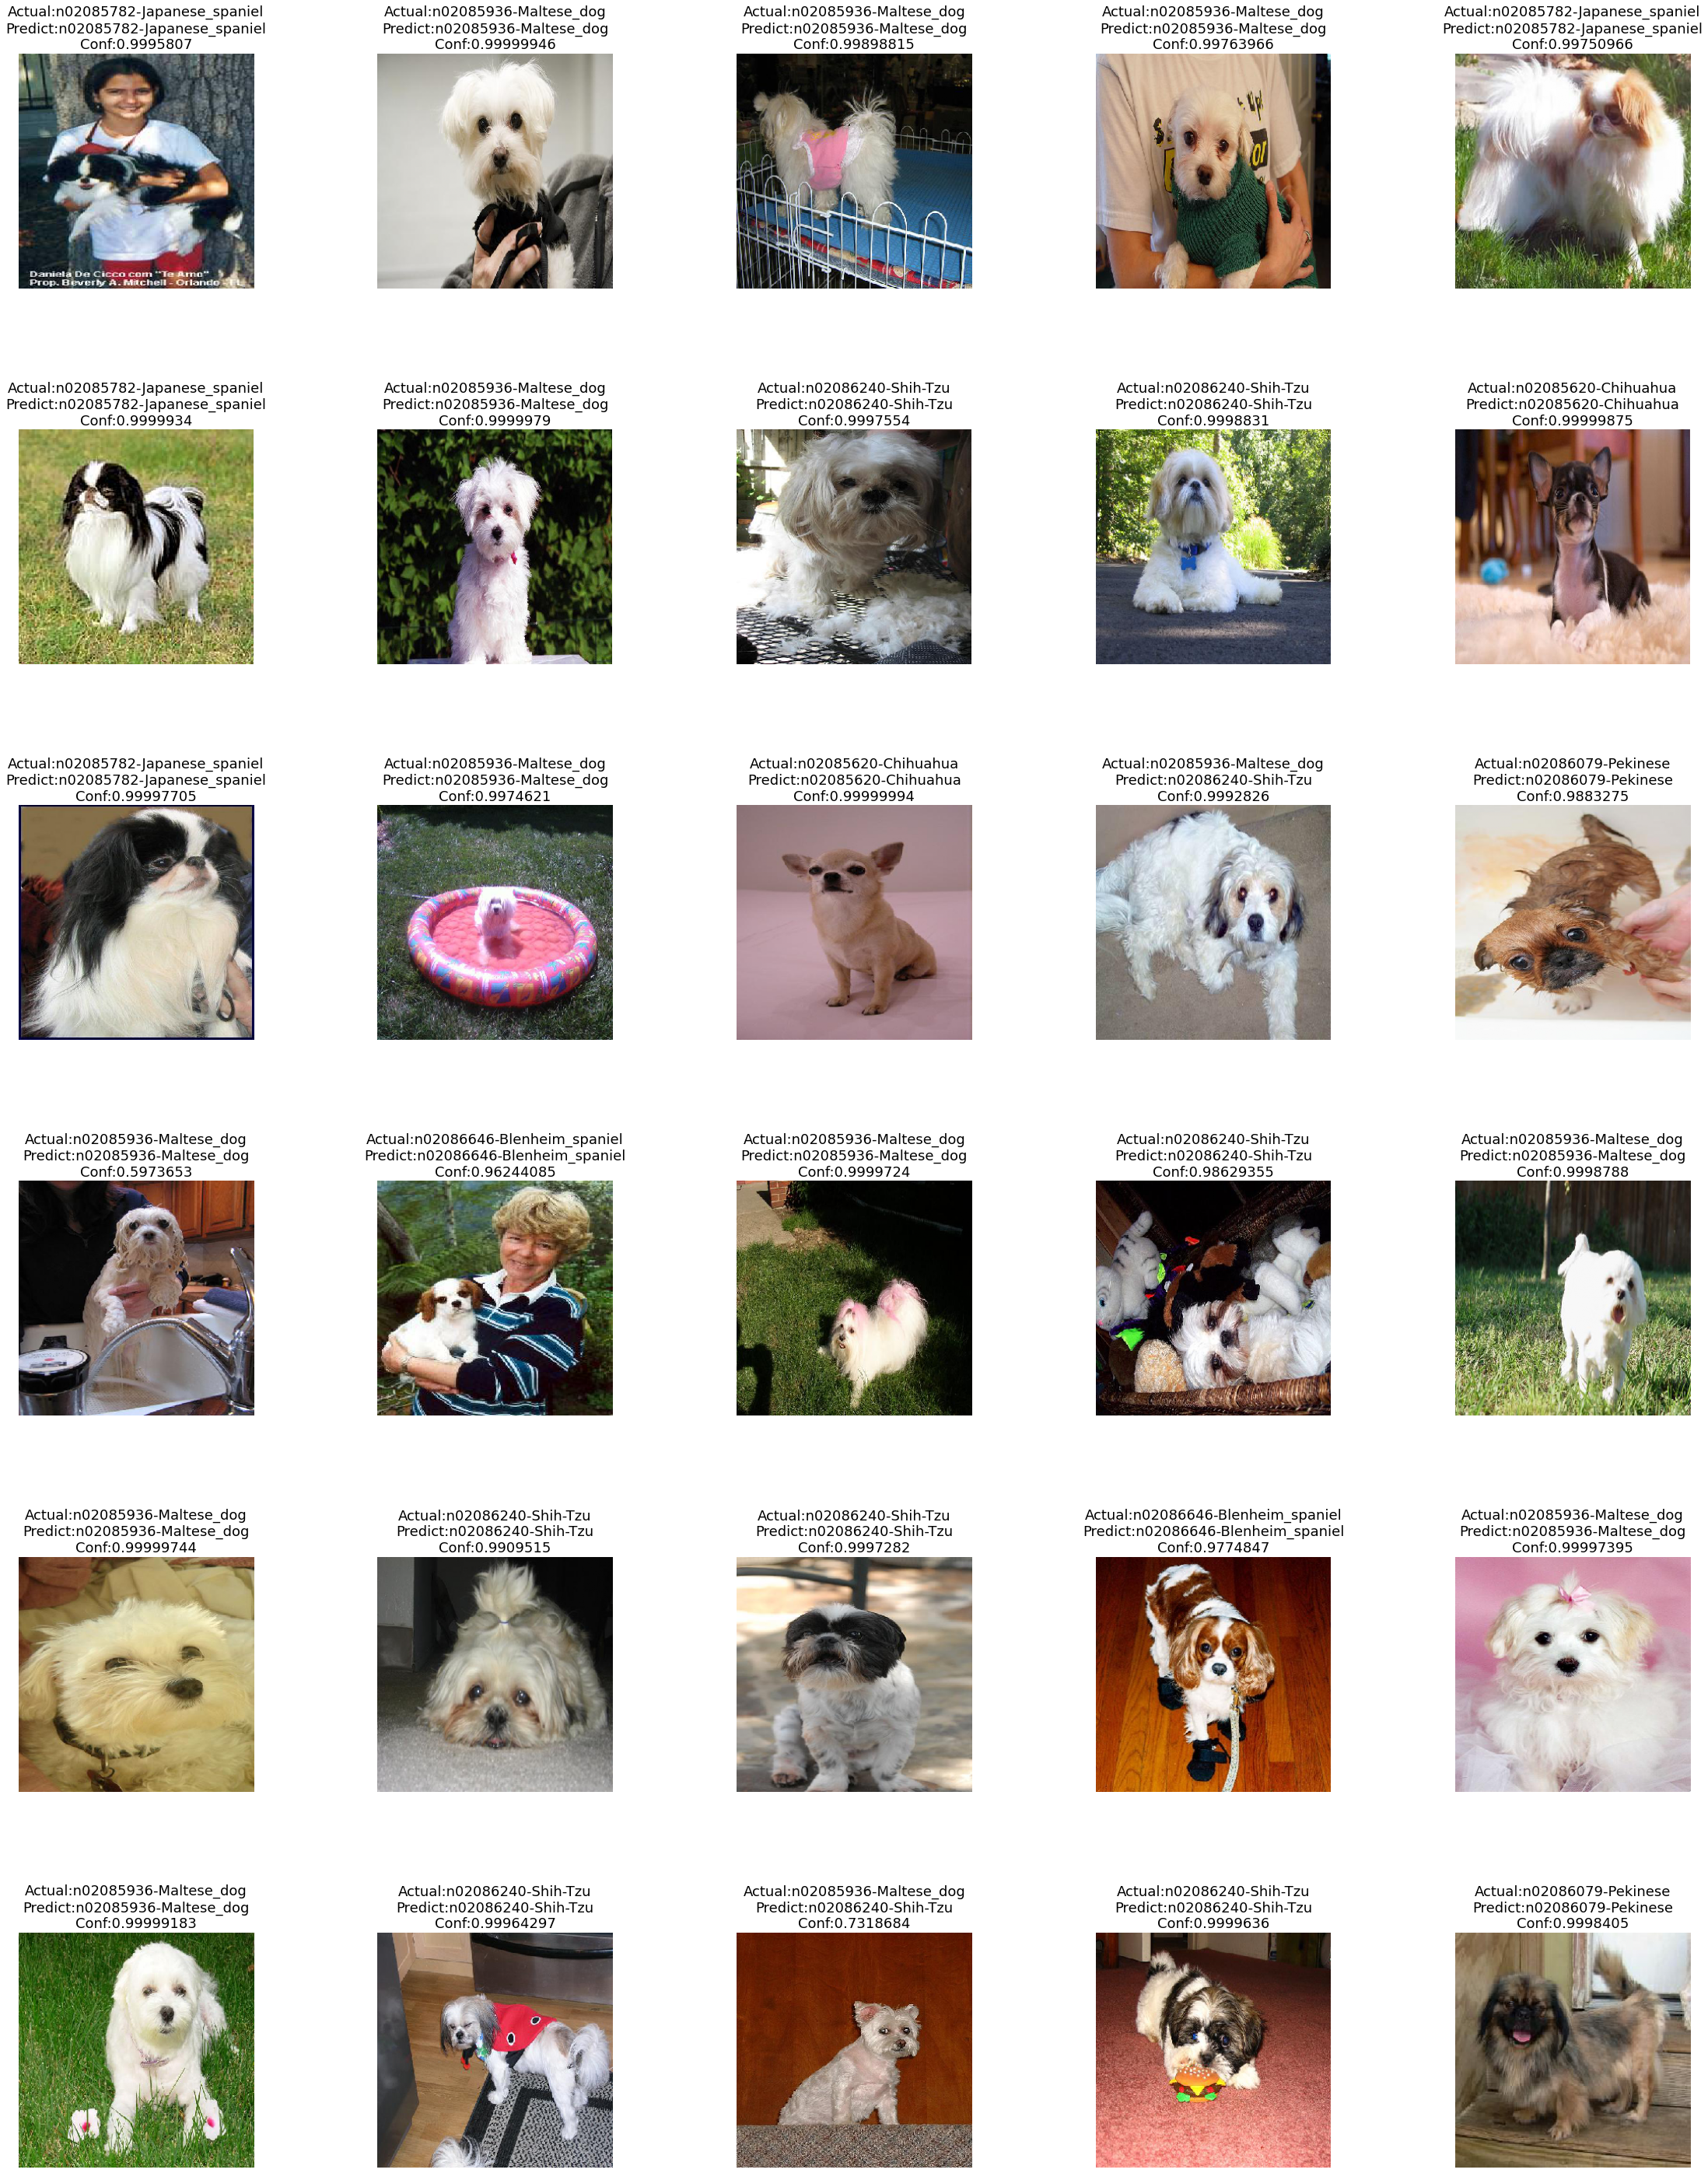

In [148]:
plt.figure(figsize = (40, 50))
for counter, i in enumerate(random.sample(range(0, len(y_test)), 30)):# random 30 images
    plt.subplot(6, 5, counter + 1)
    plt.subplots_adjust(hspace = 0.6)
    actual = str(target_labels[i])
    predicted = str(predictions[i])
    conf = str(max(test_predictions[i]))    
    plt.imshow(x_test[i].astype(np.uint8) / 255)
    plt.axis("off")
    plt.title("Actual:" + actual + "\n" + "Predict:" +predicted + "\n"+ "Conf:" +conf, fontsize = 18)
    
plt.show()
     

In [149]:
import h5py

In [150]:
model.save("InceptionV3.h5")

/home/sacko/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Comparaison des modèles

In [152]:
method = ["MODELE-CNN", "INCEPTION-V3"]

accuracy = [accuracy_cnn, accuracy_v3]

accuracy = [str(round(acc*100, 1))+'%' for acc in accuracy]

training_time = [round(excution_time_cnn,1), round(excution_time,1)]

training_time_rounded = [round(tt,1) for tt in training_time]

training_time = np.array(training_time)

training_time_x = list(training_time /min(training_time))

training_time_x = [str(round(ttx,1))+'x' for ttx in training_time_x]

dict = {'Method' : method,
        'Accuracy' : accuracy,
        'Training Time [m]' : training_time_rounded,
        'Training Time [x]' : training_time_x}
df = pd.DataFrame(dict)
display(df)

Method Accuracy  Training Time [m] Training Time [x]
0    MODELE-CNN    35.7%               57.0              1.0x
1  INCEPTION-V3    96.7%               67.5              1.2x